# Read the files

In [210]:
library("tidyverse")
library("janitor")
library("caret")
library("mlr")
library("parallelMap")
library("ggthemr")

ggthemr("fresh")

Warning message:
“New theme missing the following elements: panel.grid, plot.tag, plot.tag.position”

In [211]:
parallelStartSocket(cpus = 39)
#parallelStartMulticore(cpus = 39)

Starting parallelization in mode=socket with cpus=39.


In [212]:
df_train = readRDS("df_train_after_03FE.RData")
df_val = readRDS("df_val_after_03FE.RData")
cols_with_low_iv_values = readRDS("cols_with_low_iv_values.RData")
cols_with_woe_added = readRDS("cols_with_woe_added.RData")

In [213]:
cols_with_low_iv_values %>% cat(sep = " \n ")

nbrhud_comm_180d_violation_cnt 
 zone_type 
 mos_species 
 ses_lt_hs_pct_tract2017 
 loc_lat_lng_src 
 nbrhud_blk_grp_180d_violation_cnt 
 nbrhud_zipcode_180d_violation_cnt 
 t_day_of_yr 
 trap_trap_type 
 mos_salinarius_num_mosquitos 
 mos_unspecified_num_mosquitos 
 mos_erraticus_num_mosquitos 
 mos_tarsalis_num_mosquitos 
 trap_satellite_ind 
 t_day 
 mos_territans_num_mosquitos 
 nbrhud_comm_180d_vacancies_cnt 
 wea_ohare_tavg2_ma7 
 nbrhud_blk_grp_180d_vacancies_cnt 
 nbrhud_zipcode_180d_vacancies_cnt 
 wea_ohare_prcp 
 googtrend_deadbirds 
 wea_ohare_prcp_sum7 
 mos_restuans_num_mosquitos 
 wea_ohare_tavg2_ma60_lag21 
 wea_ohare_tmax 
 wea_ohare_prcp_sum60_lag7


# Little cleanup

In [214]:
# Remove cols_with_low_iv_values to make life a bit simplier

#df_train = df_train %>% select(-cols_with_low_iv_values)
#df_val = df_val %>% select(-cols_with_low_iv_values)

In [215]:
df_train = df_train %>% 
    rename(y=mos_any_wnv_present) %>%
    mutate(y = factor(y,levels = c(0,1), labels = c("Clean","Infected"))) %>%
                         select(-loc_census_block_group_id,
                                -loc_census_tract_id,
                                -loc_community,
                                -trap_trap_name)
df_val = df_val %>% 
    rename(y=mos_any_wnv_present) %>%
    mutate(y = factor(y,levels = c(0,1), labels = c("Clean","Infected"))) %>%
                         select(-loc_census_block_group_id,
                                -loc_census_tract_id,
                                -loc_community,
                                -trap_trap_name)

In [216]:
stopifnot(df_train %>% select_if(is.factor) %>% map_int(~length(levels(.x))) == 
              df_val %>% select_if(is.factor) %>% map_int(~length(levels(.x))))

### Remove NA rows from val set

In [217]:
df_val = df_val[complete.cases(df_val),]

### Make y the 1st col

In [218]:
make_resp_first_var = function(df){
    pred_cols = names(df %>% select(-y))
    df %>% select(y, pred_cols)
}

In [219]:
df_train = df_train %>% make_resp_first_var
df_val   = df_val   %>% make_resp_first_var

In [220]:
dim(df_train)

[1] 15257    64

In [221]:
dim(df_val)

[1] 5903   64

In [222]:
predictors = df_train %>% select(-y) %>% names

Number of levels of all factor vars:

In [223]:
df_train %>% select_if(is.factor) %>% map_int(~length(levels(.x)))

y             t_mo            t_qtr t_day_of_wk_name 
               2                6                3                5 
 loc_lat_lng_src      loc_zipcode       zone_class        zone_type 
               2               47               38                7 
  trap_trap_type      mos_species 
               4                8

## Putting train & val data together

Since `mlr` can handle these data together (much easier) using either holdout, or 5-fold CV, I'm putting these two sets together again.

In [224]:
df_model = df_train %>% bind_rows(df_val)

In [225]:
dim(df_model)

[1] 21160    64

In [226]:
cat("Holdout % : ", round(nrow(df_train)/nrow(df_model),3))

Holdout % :  0.721

# Model Setup

## Preprocess Data

In [231]:
wnv = createDummyFeatures(df_model,target = "y")
wnv = removeConstantFeatures(wnv)

Removing 2 columns: zone_class.PMD.2,trap_trap_type.SENTINEL


Creating data with **NO** mosquito variables - like mos species count, or mos species information 

In [232]:
df_model_no_mos = df_model %>% select(-starts_with("mos"))
wnv_no_mos = createDummyFeatures(df_model_no_mos,target = "y")
wnv_no_mos = removeConstantFeatures(wnv_no_mos)

Removing 2 columns: zone_class.PMD.2,trap_trap_type.SENTINEL


In [273]:
df_model_no_mos = df_model %>% select(-starts_with("mos")) %>% bind_cols(df_model["mos_tot_num_mosquitos"])
wnv_mos_count = createDummyFeatures(df_model_no_mos,target = "y")
wnv_mos_count = removeConstantFeatures(wnv_mos_count)

Removing 2 columns: zone_class.PMD.2,trap_trap_type.SENTINEL


## Create Classification Task & Split

In [235]:
tsk = makeClassifTask(data = wnv, target = "y", positive = "Infected")
tsk

Supervised task: wnv
Type: classif
Target: y
Observations: 21160
Features:
   numerics     factors     ordered functionals 
        172           0           0           0 
Missings: FALSE
Has weights: FALSE
Has blocking: FALSE
Has coordinates: FALSE
Classes: 2
   Clean Infected 
   18175     2985 
Positive class: Infected

In [236]:
tsk_no_mos = makeClassifTask(data = wnv_no_mos, target = "y", positive = "Infected")
tsk_no_mos

Supervised task: wnv_no_mos
Type: classif
Target: y
Observations: 21160
Features:
   numerics     factors     ordered functionals 
        155           0           0           0 
Missings: FALSE
Has weights: FALSE
Has blocking: FALSE
Has coordinates: FALSE
Classes: 2
   Clean Infected 
   18175     2985 
Positive class: Infected

In [274]:
tsk_mos_count = makeClassifTask(data = wnv_mos_count, target = "y", positive = "Infected")
tsk_mos_count

Supervised task: wnv_mos_count
Type: classif
Target: y
Observations: 21160
Features:
   numerics     factors     ordered functionals 
        156           0           0           0 
Missings: FALSE
Has weights: FALSE
Has blocking: FALSE
Has coordinates: FALSE
Classes: 2
   Clean Infected 
   18175     2985 
Positive class: Infected

# Feature Importance

In [237]:
fv = generateFilterValuesData(tsk, method = "anova.test")
fv

FilterValues:
Task: wnv
         name    type anova.test
1       t_day integer   5.763191
2        t_wk integer 336.653767
3 t_day_of_yr integer 371.103321
4 t_day_of_wk integer  69.448454
5  t_eval_day integer 521.900156
6   t_eval_wk integer 521.824912
... (#rows: 172, #cols: 3)

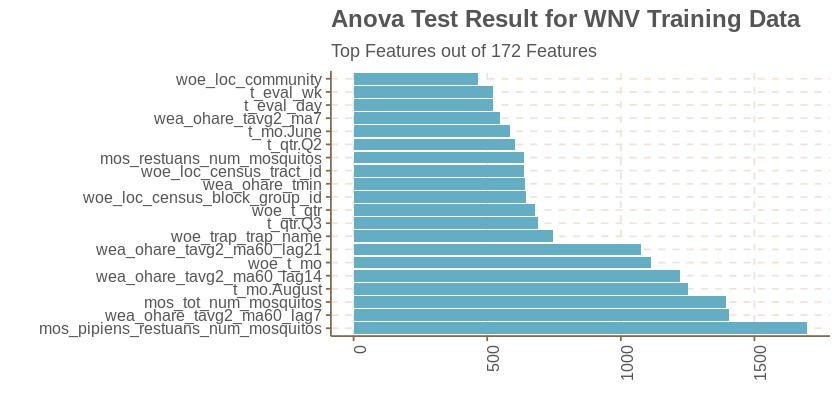

In [240]:
options(repr.plot.width=7, repr.plot.height=3.5)
plotFilterValues(fv) + 
    labs(title="Anova Test Result for WNV Training Data", subtitle="Top Features out of 172 Features") + 
    theme(axis.text.x = element_text(angle = 90)) + 
    coord_flip()

fv = generateFilterValuesData(tsk, method = c("randomForest.importance"))
fv

plotFilterValues(fv,facet.wrap.nrow = 2) + 
    labs(title="Random Forest Importance Plot", subtitle="Top Features out of 172 Features") + 
    theme(axis.text.x = element_text(angle = 90)) + 
    coord_flip()

## Build the model

In [254]:
rdesc = makeResampleDesc("Holdout", stratify = TRUE, split = 0.721)

In [255]:
lrns = list(makeLearner(id = "rpart", cl = "classif.rpart", predict.type = "prob"),
            makeLearner(id = "rf", cl = "classif.randomForest", predict.type = "prob"),
            makeLearner(id = "xgb", cl = "classif.xgboost", predict.type = "prob", nthread=25),
            makeLearner(id = "adaboost", cl = "classif.adaboostm1", predict.type = "prob"),
            makeLearner(id = "cforest", cl = "classif.cforest", predict.type = "prob"),
            makeLearner(id = "C50", cl = "classif.C50", predict.type = "prob"),
            makeLearner(id = "gbm", cl = "classif.gbm", predict.type = "prob"),
            makeLearner(id = "dbnDNN", cl = "classif.dbnDNN", predict.type = "prob"),
            makeLearner(id = "svm", cl = "classif.svm", predict.type = "prob"),
            makeLearner(id = "svm_radial", cl = "classif.svm", predict.type = "prob", kernel = "radial"),
            makeLearner(id = "extraTrees", cl = "classif.extraTrees", predict.type = "prob", numThreads = 25))

#makePreprocWrapperCaret(makeLearner(id = "eTrees_norm","classif.evtree",predict.type = "prob"), ppc.center = TRUE, ppc.scale = TRUE)

In [256]:
meas = list(auc, mmce, f1, tpr, fpr, fnr, timetrain)

In [44]:
bmr = readRDS('large_cache/bmr_001.RData')
#parallelStartSocket(cpus = 39)
#bmr = benchmark(learners = lrns, tasks = tsk, resamplings = rdesc, measures = meas, show.info = TRUE)
#parallelStop()

Exporting objects to slaves for mode socket: .mlr.slave.options
Mapping in parallel: mode = socket; cpus = 39; elements = 11.


In [278]:
lrns_2 = list(makeLearner(id = "rf", cl = "classif.randomForest", predict.type = "prob"),
            makeLearner(id = "xgb", cl = "classif.xgboost", predict.type = "prob", nthread=25),
            makeLearner(id = "extraTrees", cl = "classif.extraTrees", predict.type = "prob", numThreads = 25))

parallelStartSocket(cpus = 39)
bmr_no_mos = benchmark(learners = lrns_2, tasks = tsk_no_mos, resamplings = rdesc, measures = meas, show.info = TRUE)
parallelStop()

Starting parallelization in mode=socket with cpus=39.
Exporting objects to slaves for mode socket: .mlr.slave.options
Mapping in parallel: mode = socket; cpus = 39; elements = 3.
Stopped parallelization. All cleaned up.


In [279]:
parallelStartSocket(cpus = 39)
bmr_mos_count = benchmark(learners = lrns_2, tasks = tsk_mos_count, resamplings = rdesc, measures = meas, show.info = TRUE)
parallelStop()

Starting parallelization in mode=socket with cpus=39.
Exporting objects to slaves for mode socket: .mlr.slave.options
Mapping in parallel: mode = socket; cpus = 39; elements = 3.
Stopped parallelization. All cleaned up.


In [280]:
bmr

   task.id learner.id auc.test.mean mmce.test.mean f1.test.mean tpr.test.mean
1      wnv      rpart     0.7816962     0.10721545    0.5043070     0.3865546
2      wnv         rf     0.9816441     0.02726965    0.8961960     0.8343337
3      wnv        xgb     0.8963596     0.10044038    0.5668371     0.4657863
4      wnv   adaboost     0.8756317     0.11500678    0.4211424     0.2965186
5      wnv    cforest     0.9341287     0.10924797    0.3909348     0.2484994
6      wnv        C50     0.9078098     0.07859079    0.6890080     0.6170468
7      wnv        gbm     0.7784532     0.14109079    0.0000000     0.0000000
8      wnv     dbnDNN     0.5000000     0.14109079    0.0000000     0.0000000
9      wnv        svm     0.9647349     0.03743225    0.8507765     0.7563025
10     wnv svm_radial     0.9646048     0.03726287    0.8517520     0.7587035
11     wnv extraTrees     0.9859502     0.02625339    0.9014622     0.8511405
   fpr.test.mean fnr.test.mean timetrain.test.mean
1    0.024058

In [281]:
bmr_no_mos

     task.id learner.id auc.test.mean mmce.test.mean f1.test.mean tpr.test.mean
1 wnv_no_mos         rf     0.9701157     0.04352981    0.8330084     0.7695078
2 wnv_no_mos        xgb     0.8519050     0.12415312    0.4976011     0.4357743
3 wnv_no_mos extraTrees     0.9791652     0.03963415    0.8528302     0.8139256
  fpr.test.mean fnr.test.mean timetrain.test.mean
1    0.01281798     0.2304922              74.889
2    0.05186354     0.5642257               0.304
3    0.01557878     0.1860744               3.823

In [282]:
bmr_mos_count

        task.id learner.id auc.test.mean mmce.test.mean f1.test.mean
1 wnv_mos_count         rf     0.9769225     0.03455285    0.8668407
2 wnv_mos_count        xgb     0.8805896     0.11128049    0.4714401
3 wnv_mos_count extraTrees     0.9838793     0.03235095    0.8779553
  tpr.test.mean fpr.test.mean fnr.test.mean timetrain.test.mean
1     0.7971188   0.006901992     0.2028812              72.829
2     0.3517407   0.023072372     0.6482593               0.281
3     0.8247299   0.008873989     0.1752701               3.912

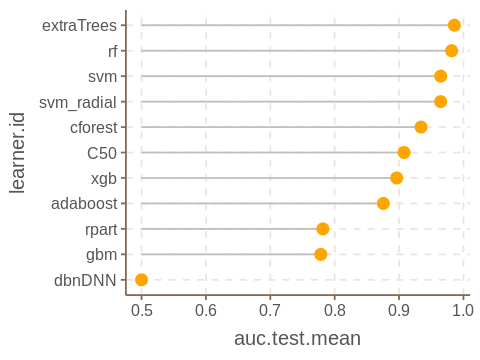

In [95]:
options(repr.plot.width=4, repr.plot.height=3)
getBMRAggrPerformances(bmr, as.df = T) %>%
    mutate(learner.id = forcats::fct_reorder(learner.id,auc.test.mean,.desc = F)) %>%
    ggplot(aes(learner.id, auc.test.mean))+
    geom_segment(aes(xend=learner.id,yend=0.5),color="gray")+
    geom_point(size=3,color="orange")+
    coord_flip()

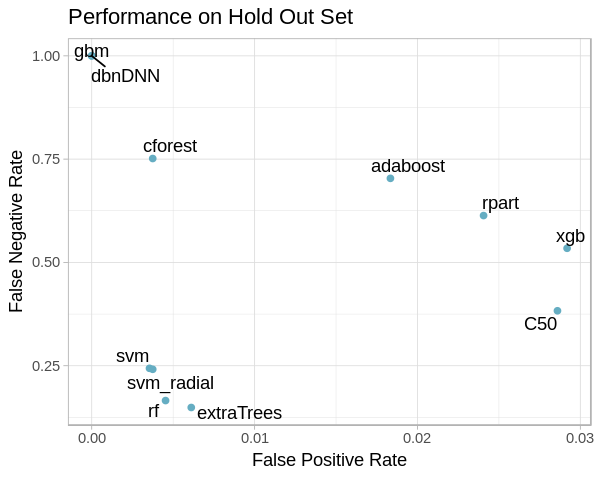

In [135]:
library("ggrepel")
ggthemr_reset()
options(repr.plot.width=5, repr.plot.height=4)
getBMRAggrPerformances(bmr, as.df = T) %>%
    ggplot(aes(x=fpr.test.mean, y=fnr.test.mean)) +
    geom_point()+#(aes(color=learner.id))+
    geom_text_repel(aes(label=learner.id),force = 2)+#,color=learner.id))+
    theme_light()+
    theme(legend.position = "none")+
    labs(x="False Positive Rate", y="False Negative Rate", title = "Performance on Hold Out Set")

In [96]:
df = generateThreshVsPerfData(bmr, measures = list(fpr, tpr, mmce))

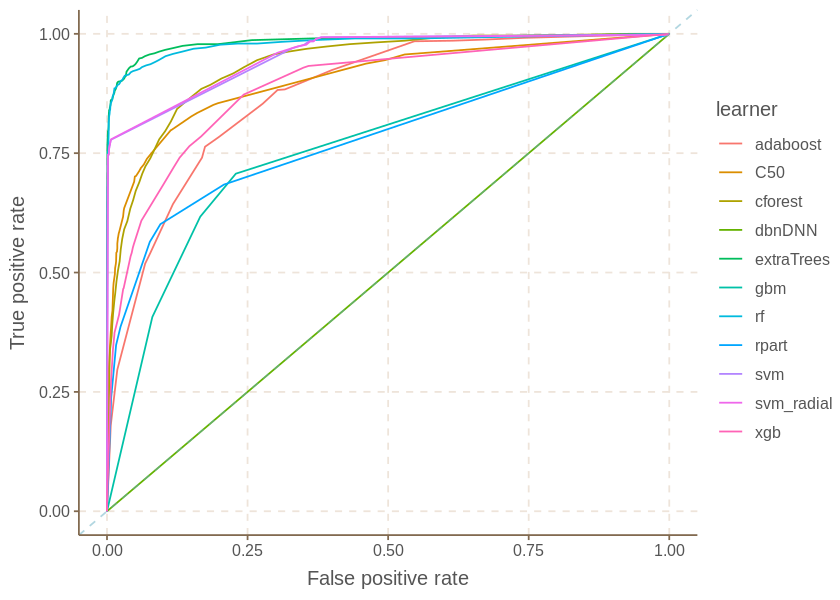

In [97]:
options(repr.plot.width=7, repr.plot.height=5)
plotROCCurves(df)

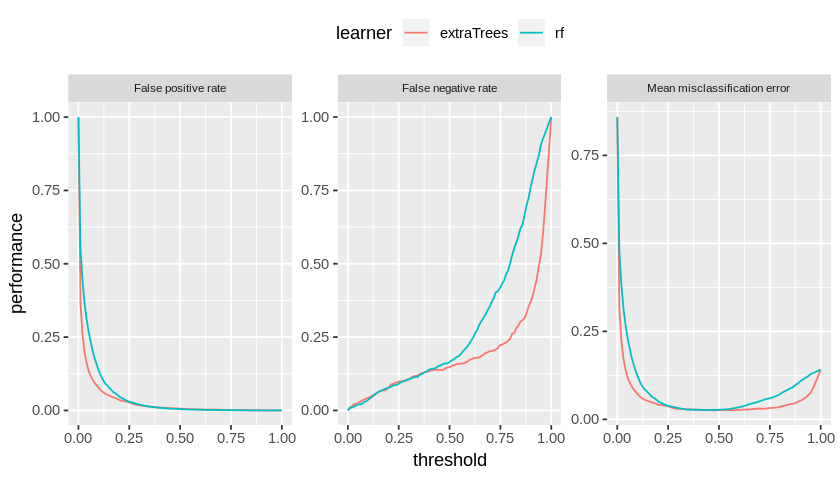

In [148]:
options(repr.plot.width=7, repr.plot.height=4)
generateThreshVsPerfData(obj = bmr$results$wnv[c("extraTrees","rf")],measures = list(fpr, fnr, mmce)) %>%
    plotThreshVsPerf() +
    theme(strip.text.x = element_text(size = 7), legend.position = "top")

In [100]:
saveRDS(object = bmr, file = "bmr_001.RData")

# Tuning

The extraTrees model seems to be the best. Can tuning make the performance better?

Without tuning, the baseline result...

In [203]:
preds = getBMRPredictions(bmr, learner.ids = "extraTrees",drop = T)

In [153]:
calculateROCMeasures(preds)

          predicted
true       Clean     Infected                         
  Clean    5040      31        tpr: 0.85   fnr: 0.15  
  Infected 124       709       fpr: 0.01   tnr: 0.99  
           ppv: 0.96 for: 0.02 lrp: 139.23 acc: 0.97  
           fdr: 0.04 npv: 0.98 lrm: 0.15   dor: 929.59


Abbreviations:
tpr - True positive rate (Sensitivity, Recall)
fpr - False positive rate (Fall-out)
fnr - False negative rate (Miss rate)
tnr - True negative rate (Specificity)
ppv - Positive predictive value (Precision)
for - False omission rate
lrp - Positive likelihood ratio (LR+)
fdr - False discovery rate
npv - Negative predictive value
acc - Accuracy
lrm - Negative likelihood ratio (LR-)
dor - Diagnostic odds ratio

In [156]:
ctrl = makeTuneControlGrid()
ctrl

Tune control: TuneControlGrid
Same resampling instance: TRUE
Imputation value: <worst>
Start: <NULL>

Tune threshold: FALSE
Further arguments: resolution=10

In [157]:
getLearnerParamSet("classif.extraTrees")

                           Type  len   Def         Constr Req Tunable Trafo
ntree                   integer    -   500       1 to Inf   -    TRUE     -
mtry                    integer    -     -       1 to Inf   -    TRUE     -
nodesize                integer    -     1    -Inf to Inf   -    TRUE     -
numRandomCuts           integer    -     1    -Inf to Inf   -    TRUE     -
evenCuts                logical    - FALSE              -   -    TRUE     -
numThreads              integer    -     1       1 to Inf   -    TRUE     -
subsetSizes       integervector <NA>     -    -Inf to Inf   -    TRUE     -
subsetGroups            untyped    -     -              -   -    TRUE     -
tasks             integervector <NA>     -       1 to Inf   -    TRUE     -
probOfTaskCuts          numeric    -     -         0 to 1   -    TRUE     -
numRandomTaskCuts       integer    -     1       1 to Inf   -    TRUE     -
na.action              discrete    -  stop stop,zero,fuse   -    TRUE     -

In [181]:
ps = makeParamSet(
    makeDiscreteParam("ntree", values = c(500)),
    makeDiscreteParam("mtry", values = c(50,55,60,65)),
    makeDiscreteParam("numRandomCuts", values = c(7,10,13))
)
ps

                  Type len Def      Constr Req Tunable Trafo
ntree         discrete   -   -         500   -    TRUE     -
mtry          discrete   -   - 50,55,60,65   -    TRUE     -
numRandomCuts discrete   -   -     7,10,13   -    TRUE     -

In [182]:
parallelStartSocket(cpus = 39)

lrn_ex = makeLearner(cl = "classif.extraTrees", predict.type = "prob")
res = tuneParams(learner = lrn_ex, task = tsk, resampling = rdesc, par.set = ps, control = ctrl, measures = meas,show.info = F)

Exporting objects to slaves for mode socket: .mlr.slave.options
Mapping in parallel: mode = socket; cpus = 39; elements = 12.


In [183]:
res

Tune result:
Op. pars: ntree=500; mtry=50; numRandomCuts=10
auc.test.mean=0.9893297,mmce.test.mean=0.0225271,f1.test.mean=0.9162996,tpr.test.mean=0.8739496,fpr.test.mean=0.0055216,fnr.test.mean=0.1260504,timetrain.test.mean=213.2420000

ntree,mtry,numRandomCuts,auc.test.mean,mmce.test.mean,f1.test.mean,tpr.test.mean,fpr.test.mean,fnr.test.mean,timetrain.test.mean,iteration,exec.time
500,50,7,0.9892243,0.02049458,0.9240427,0.8835534,0.004732794,0.1164466,166.046,1,168.291
500,55,7,0.9889102,0.02151084,0.9199748,0.8763505,0.004732794,0.1236495,184.294,2,186.521
500,60,7,0.9891128,0.02235772,0.9169811,0.8751501,0.005521593,0.1248499,203.569,3,205.967
500,65,7,0.9886712,0.02320461,0.9133460,0.8667467,0.005127194,0.1332533,195.314,4,198.069
500,50,10,0.9893297,0.02252710,0.9162996,0.8739496,0.005521593,0.1260504,213.242,5,214.964
500,55,10,0.9876912,0.02134146,0.9209536,0.8811525,0.005324394,0.1188475,227.420,6,229.002
500,60,10,0.9881353,0.02286585,0.9152542,0.8751501,0.006113193,0.1248499,246.127,7,247.989
500,65,10,0.9879933,0.02235772,0.9171895,0.8775510,0.005915993,0.1224490,241.776,8,243.252
500,50,13,0.9885457,0.02235772,0.9171895,0.8775510,0.005915993,0.1224490,245.650,9,247.024
500,55,13,0.9891687,0.02168022,0.9196989,0.8799520,0.005521593,0.1200480,264.442,10,265.724


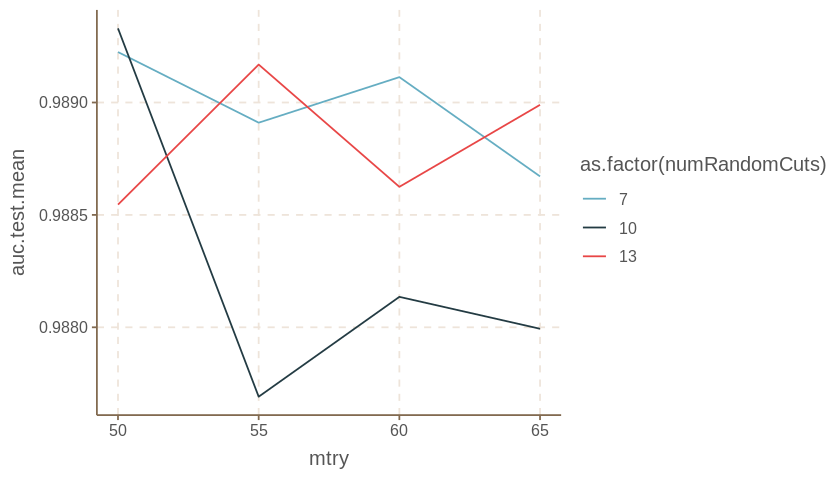

In [184]:
res_df = generateHyperParsEffectData(res,partial.dep = T)[[1]]
res_df

res_df%>%
    ggplot(aes(x=mtry, y = auc.test.mean, color = as.factor(numRandomCuts)))+
    geom_line()

In [197]:
parallelStartSocket(cpus = 39)

lrn_ex = setHyperPars(makeLearner(cl = "classif.extraTrees", predict.type = "prob"), par.vals = res$x)
r = resample(learner = lrn_ex, task = tsk, resampling = rdesc, measures = meas)
pred = getRRPredictions(r)
calculateROCMeasures(pred)

Starting parallelization in mode=socket with cpus=39.
Exporting objects to slaves for mode socket: .mlr.slave.options
Resampling: holdout
Measures:             auc         mmce        f1          tpr         fpr         fnr         timetrain   
Mapping in parallel: mode = socket; cpus = 39; elements = 1.


Aggregated Result: auc.test.mean=0.9894498,mmce.test.mean=0.0235434,f1.test.mean=0.9135034,tpr.test.mean=0.8811525,fpr.test.mean=0.0078880,fnr.test.mean=0.1188475,timetrain.test.mean=145.7290000




          predicted
true       Clean     Infected                         
  Clean    5031      40        tpr: 0.88   fnr: 0.12  
  Infected 99        734       fpr: 0.01   tnr: 0.99  
           ppv: 0.95 for: 0.02 lrp: 111.71 acc: 0.98  
           fdr: 0.05 npv: 0.98 lrm: 0.12   dor: 932.51


Abbreviations:
tpr - True positive rate (Sensitivity, Recall)
fpr - False positive rate (Fall-out)
fnr - False negative rate (Miss rate)
tnr - True negative rate (Specificity)
ppv - Positive predictive value (Precision)
for - False omission rate
lrp - Positive likelihood ratio (LR+)
fdr - False discovery rate
npv - Negative predictive value
acc - Accuracy
lrm - Negative likelihood ratio (LR-)
dor - Diagnostic odds ratio

In [265]:
parallelStop()

Stopped parallelization. All cleaned up.


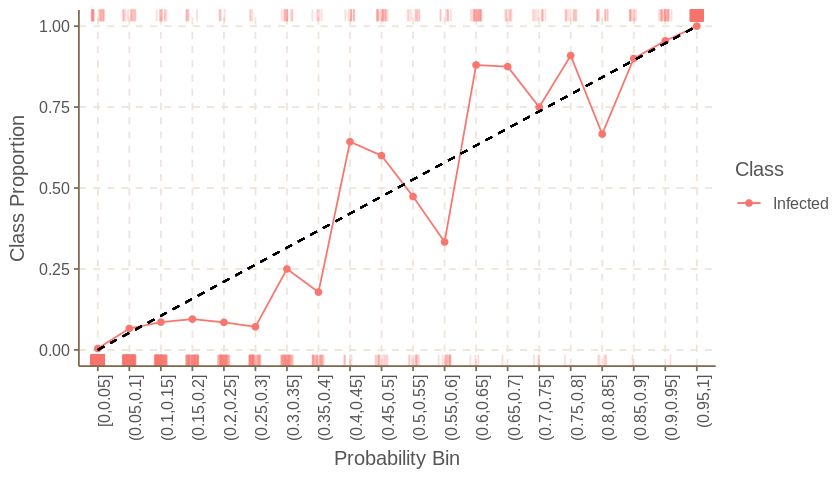

In [205]:
cal = generateCalibrationData(pred)
plotCalibration(cal, smooth = F)

In [208]:
setThreshold(pred, threshold = .5) %>% calculateROCMeasures

          predicted
true       Clean     Infected                         
  Clean    5031      40        tpr: 0.88   fnr: 0.12  
  Infected 99        734       fpr: 0.01   tnr: 0.99  
           ppv: 0.95 for: 0.02 lrp: 111.71 acc: 0.98  
           fdr: 0.05 npv: 0.98 lrm: 0.12   dor: 932.51


Abbreviations:
tpr - True positive rate (Sensitivity, Recall)
fpr - False positive rate (Fall-out)
fnr - False negative rate (Miss rate)
tnr - True negative rate (Specificity)
ppv - Positive predictive value (Precision)
for - False omission rate
lrp - Positive likelihood ratio (LR+)
fdr - False discovery rate
npv - Negative predictive value
acc - Accuracy
lrm - Negative likelihood ratio (LR-)
dor - Diagnostic odds ratio

In [209]:
setThreshold(pred, threshold = .25) %>% calculateROCMeasures

          predicted
true       Clean     Infected                        
  Clean    4916      155       tpr: 0.94  fnr: 0.06  
  Infected 52        781       fpr: 0.03  tnr: 0.97  
           ppv: 0.83 for: 0.01 lrp: 30.67 acc: 0.96  
           fdr: 0.17 npv: 0.99 lrm: 0.06  dor: 476.35


Abbreviations:
tpr - True positive rate (Sensitivity, Recall)
fpr - False positive rate (Fall-out)
fnr - False negative rate (Miss rate)
tnr - True negative rate (Specificity)
ppv - Positive predictive value (Precision)
for - False omission rate
lrp - Positive likelihood ratio (LR+)
fdr - False discovery rate
npv - Negative predictive value
acc - Accuracy
lrm - Negative likelihood ratio (LR-)
dor - Diagnostic odds ratio

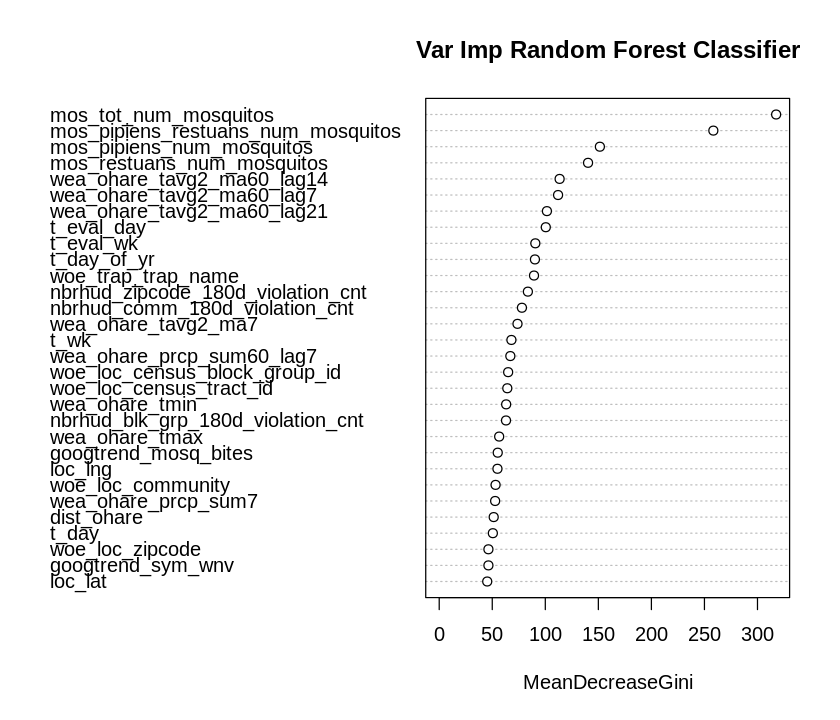

In [253]:
library("randomForest")
options(repr.plot.width=7, repr.plot.height=6)
varImpPlot(bmr$results$wnv$rf$models[[1]]$learner.model, main = "Var Imp Random Forest Classifier")

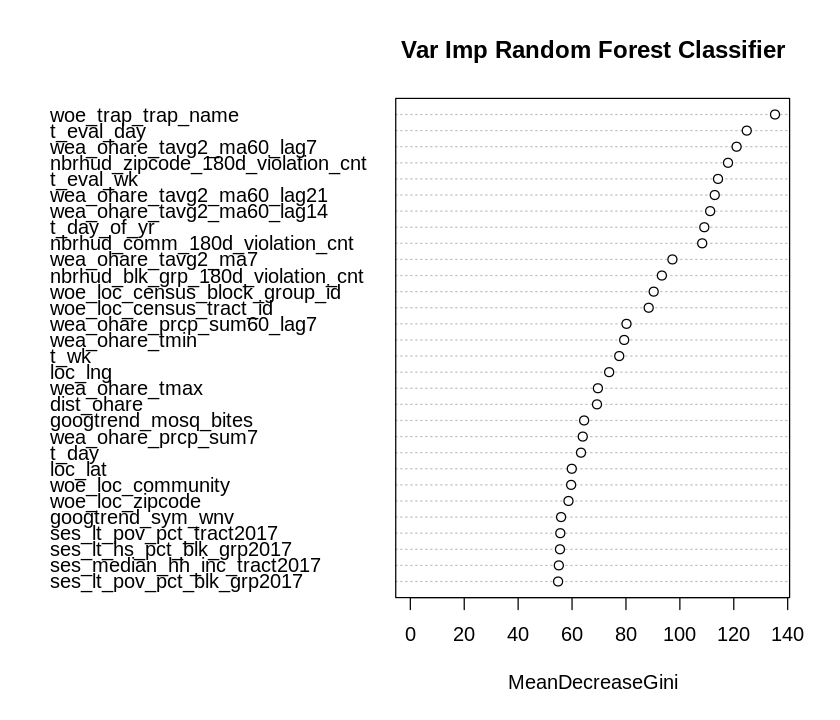

In [259]:
library("randomForest")
options(repr.plot.width=7, repr.plot.height=6)
varImpPlot(bmr_no_mos$results$wnv_no_mos$rf$models[[1]]$learner.model, main = "Var Imp Random Forest Classifier")

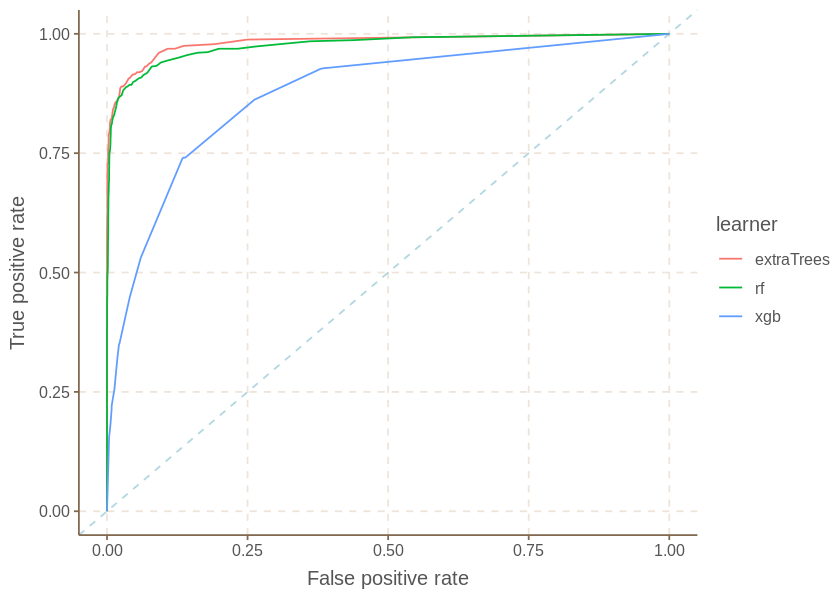

In [283]:
options(repr.plot.width=7, repr.plot.height=5)
mergeBenchmarkResults(list(bmr_no_mos,bmr_mos_count)) %>%
    generateThreshVsPerfData(measures = list(fpr, tpr, mmce)) %>%
    plotROCCurves()